<a href="https://colab.research.google.com/github/ZTHussain/Classifier/blob/main/Unet_with_EfficentNet_b7_backbone.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
import torchvision
import torch.nn.functional as F
from torch.autograd import Variable

from PIL import Image
import cv2
import albumentations as A

import time
import os
from tqdm.notebook import tqdm
!pip install -q torchsummary

from torchsummary import summary

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Segmentation Dataset


- 0 - sky
- 1 - building
- 2 - pole
- 3 - road
- 4 - pavement
- 5 - tree
- 6 - signsymbol
- 7 - fence
- 8 - car
- 9 - pedestrain
- 10 - bicyclist
- 11 - unlabeled 


In [2]:
!gdown https://drive.google.com/file/d/1QPzrKcoiFLD0rFnEpSsaTDuVxCLs2Ani/view?usp=share_link --fuzzy

Downloading...
From: https://drive.google.com/uc?id=1QPzrKcoiFLD0rFnEpSsaTDuVxCLs2Ani
To: /content/A3_Dataset.zip
100% 126M/126M [00:03<00:00, 41.4MB/s]


In [3]:
!unzip /content/A3_Dataset.zip

Archive:  /content/A3_Dataset.zip
   creating: A3_Dataset/
   creating: A3_Dataset/dataset1/
   creating: A3_Dataset/dataset1/annotations_prepped_test/
  inflating: A3_Dataset/dataset1/annotations_prepped_test/0016E5_07959.png  
  inflating: A3_Dataset/dataset1/annotations_prepped_test/0016E5_07961.png  
  inflating: A3_Dataset/dataset1/annotations_prepped_test/0016E5_07963.png  
  inflating: A3_Dataset/dataset1/annotations_prepped_test/0016E5_07965.png  
  inflating: A3_Dataset/dataset1/annotations_prepped_test/0016E5_07967.png  
  inflating: A3_Dataset/dataset1/annotations_prepped_test/0016E5_07969.png  
  inflating: A3_Dataset/dataset1/annotations_prepped_test/0016E5_07971.png  
  inflating: A3_Dataset/dataset1/annotations_prepped_test/0016E5_07973.png  
  inflating: A3_Dataset/dataset1/annotations_prepped_test/0016E5_07975.png  
  inflating: A3_Dataset/dataset1/annotations_prepped_test/0016E5_07977.png  
  inflating: A3_Dataset/dataset1/annotations_prepped_test/0016E5_07979.png  
 

In [4]:
TRAIN_IMAGE_PATH =  '/content/A3_Dataset/dataset1/images_prepped_train/'
TRAIN_MASK_PATH = '/content/A3_Dataset/dataset1/annotations_prepped_train/'
TEST_IMAGE_PATH = '/content/A3_Dataset/dataset1/images_prepped_test/'
TEST_MASK_PATH ='/content/A3_Dataset/dataset1/annotations_prepped_test/'

In [5]:
n_classes = 12
#name = []
def create_df(IMAGE_PATH):
    name = []
    for dirname, _, filenames in os.walk(IMAGE_PATH):
        for filename in filenames:
            name.append(filename.split('.')[0])

    return pd.DataFrame({'id': name}, index = np.arange(0, len(name)))

train_df = create_df(TRAIN_IMAGE_PATH)
test_df= create_df(TEST_IMAGE_PATH)

print('Train Images: ', len(train_df))
print('Test Images: ', len(test_df))

Train Images:  367
Test Images:  101


In [6]:
X_train, X_val = train_test_split(train_df['id'].values, test_size=0.2, random_state=19)

print('Train Size   : ', len(X_train))
print('Val Size     : ', len(X_val))
print('Test Size    : ', len(test_df))

Train Size   :  293
Val Size     :  74
Test Size    :  101


In [7]:
import matplotlib
print(matplotlib.rcParams['image.cmap'])

viridis


Image Size (360, 480, 3)
Mask Size (360, 480)


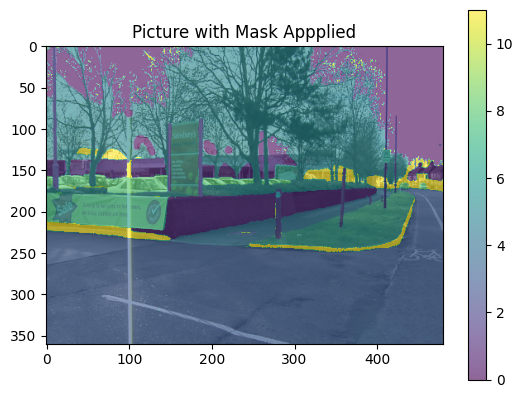

In [8]:
img = Image.open(TRAIN_IMAGE_PATH + '/' + train_df['id'][150] + '.png')
mask = Image.open(TRAIN_MASK_PATH + '/' + train_df['id'][150] + '.png')
print('Image Size', np.asarray(img).shape)
print('Mask Size', np.asarray(mask).shape)


plt.imshow(img, cmap = 'viridis')
msk = plt.imshow(mask, alpha=0.6, cmap ='viridis')
plt.title('Picture with Mask Appplied')
#plt.show()

# Add a colorbar to show the mapping between colors and data values
plt.colorbar(msk)

# Show the plot
plt.show()

In [9]:
from torchvision import transforms as T

class Dataset(Dataset):
    
    def __init__(self, img_path, mask_path, X, mean, std, transform=None):
        self.img_path = img_path
        self.mask_path = mask_path
        self.X = X
        self.transform = transform
        self.mean = mean
        self.std = std

    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        img = cv2.imread(self.img_path + self.X[idx] + '.png')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.mask_path + self.X[idx] + '.png', cv2.IMREAD_GRAYSCALE)
        
        if self.transform is not None:
            aug = self.transform(image=img, mask=mask)
            img = Image.fromarray(aug['image'])
            mask = aug['mask']
        
        if self.transform is None:
            img = Image.fromarray(img)
        
        t = T.Compose([T.ToTensor(), T.Normalize(self.mean, self.std)])
        img = t(img)
        mask = torch.from_numpy(mask).long()
            
        return img, mask

In [10]:
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]

t_train = A.Compose([A.Resize(256, 256, interpolation=cv2.INTER_NEAREST), A.HorizontalFlip(), A.VerticalFlip(), 
                     A.GridDistortion(p=0.2),
                     A.GaussNoise()])

t_val = A.Compose([A.Resize(256, 256, interpolation=cv2.INTER_NEAREST), A.HorizontalFlip(),
                   A.GridDistortion(p=0.2)])

#datasets
train_set = Dataset(TRAIN_IMAGE_PATH, TRAIN_MASK_PATH, X_train, mean, std, t_train)
val_set = Dataset(TRAIN_IMAGE_PATH, TRAIN_MASK_PATH, X_val, mean, std, t_val)

#dataloader
batch_size= 8 

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=True)

# Model

In [17]:
!pip install -q segmentation-models-pytorch
import segmentation_models_pytorch as smp


model = smp.Unet('efficientnet-b7', encoder_weights='imagenet', classes=12, activation=None, encoder_depth=5, decoder_channels=[256, 128, 64, 32, 16])

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b7-dcc49843.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b7-dcc49843.pth
100%|██████████| 254M/254M [00:03<00:00, 75.7MB/s]


In [18]:
# Calculate pixel accuracy over a batch of images
def pixel_accuracy(output, mask):
    with torch.no_grad():
        output = torch.argmax(F.softmax(output, dim=1), dim=1)
        correct = torch.eq(output, mask).int()
        accuracy = float(correct.sum()) / float(correct.numel())
    return accuracy

In [19]:
# Calculate mean Intersection-over-Union over a batch of images
def mIoU(pred_mask, mask, smooth=1e-10, n_classes=5):
    with torch.no_grad():
        pred_mask = F.softmax(pred_mask, dim=1)
        pred_mask = torch.argmax(pred_mask, dim=1)
        pred_mask = pred_mask.contiguous().view(-1)
        mask = mask.contiguous().view(-1)

        iou_per_class = []
        for clas in range(0, n_classes): #loop per pixel class
            true_class = pred_mask == clas
            true_label = mask == clas

            if true_label.long().sum().item() == 0: #no exist label in this loop
                iou_per_class.append(np.nan)
            else:
                intersect = torch.logical_and(true_class, true_label).sum().float().item()
                union = torch.logical_or(true_class, true_label).sum().float().item()

                iou = (intersect + smooth) / (union +smooth)
                iou_per_class.append(iou)
        return np.nanmean(iou_per_class)

In [20]:
# Inner loop for running the model for 1 epoch over a given loader

def run_1_epoch(model, loss_fn, loader, optimizer = None, train = False):
  
  if train:
    model.train()
  else:
    model.eval()


  total_correct_preds = 0
  
  total_loss = 0

  # Number of images we can get by the loader
  total_samples_in_loader = len(loader.dataset)
  
  # number of batches we can get by the loader 
  total_batches_in_loader = len(loader)

  for image_batch, labels in tqdm(loader):
    
    # Transfer image_batch to GPU if available
    image_batch = image_batch.to(device)
    labels = labels.to(device)
    
    # Zeroing out the gradients for parameters
    if train:
      assert optimizer is not None, "Optimizer must be provided if train=True"
      optimizer.zero_grad()
    
    # Forward pass on the input batch
    output = model(image_batch)

    # Acquire predicted class indices
    _, predicted = torch.max(output.data, 1) # the dimension 1 corresponds to max along the rows 
    
    # Removing extra last dimension from output tensor
    #output.squeeze_(-1)

    # Compute the loss for the minibatch
    loss = loss_function(output, labels)
    
    # Backpropagation
    if train:
      loss.backward()
    
    # Update the parameters using the gradients
    if train:
      optimizer.step()
    
    # Extra variables for calculating loss and accuracy
    # count total predictions for accuracy calcutuon for this epoch
    #total_correct_preds += (predicted == labels).sum().item()

    total_loss += loss.item()

  loss = total_loss / total_batches_in_loader
  accuracy = pixel_accuracy(output, labels)
  mean_IoU = mIoU(output, labels)

  return loss, accuracy, mean_IoU

# Training Configuration

In [21]:
# Select a loss function
loss_function = torch.nn.CrossEntropyLoss()

# Select an optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Define the learning rate scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=40, gamma=0.1)
# For more on schedulers please visit:
# https://towardsdatascience.com/a-visual-guide-to-learning-rate-schedulers-in-pytorch-24bbb262c863

# Set the number of epochs
# This variable is used in the main training loop
epochs = 10

model.to(device);

In [22]:
# Initializing variables for starting a new training
# Some helper variables

train_accuracies = []
val_accuracies = []

train_losses = []
val_losses = []

train_mIoUs = []
val_mIoUs = []

val_mIoU_max = -1

checkpoint_path = '/content/checkpoint_norm_aug_tensorboard.pth'
best_val_checkpoint_path = '/content/best_val_checkpoint_norm_aug_tensorboard.pth'

# Start epoch is zero for new training
start_epoch = 0

## Main Training Loop

In [23]:
# Main training and validation loop for n number of epochs
for epoch in range(start_epoch, epochs):

  # Train model for one epoch

  # Get the current learning rate from the optimizer
  current_lr = optimizer.param_groups[0]['lr']

  print("Epoch %d: Train \nLearning Rate: %.6f"%(epoch, current_lr))
  train_loss, train_accuracy, train_mIoU  = run_1_epoch(model, loss_function, train_loader, optimizer, train= True)

  # Update the learning rate scheduler
  scheduler.step()

  # Lists for train loss and accuracy for plotting
  train_losses.append(train_loss)
  train_accuracies.append(train_accuracy)
  train_mIoUs.append(train_mIoU)

  # Validate the model on validation set
  print("Epoch %d: Validation"%(epoch))
  with torch.no_grad():
    val_loss, val_accuracy, val_mIoU  = run_1_epoch(model, loss_function, val_loader, optimizer, train= False)
  
  # Lists for val loss and accuracy for plotting
  val_losses.append(val_loss)
  val_accuracies.append(val_accuracy)
  val_mIoUs.append(val_mIoU)

  # The "add_scalar" function adds a new metric to the tensorboard log
  # It is gnerally given 3 arguments:
  # tag: Name of the metric
  # scalar_value = the value of the metric to record
  # global_step = on which milestone to record the scalar value which in our
  # case is the epoch
  # writer.add_scalar(tag = "Loss/train", scalar_value = train_loss, global_step = epoch)
  # writer.add_scalar(tag = "accuracy/train", scalar_value = train_accuracy, global_step = epoch)

  # writer.add_scalar(tag = "Loss/val", scalar_value = val_loss, global_step = epoch)
  # writer.add_scalar(tag = "accuracy/val", scalar_value = val_accuracy, global_step = epoch)

  print('train loss: %.4f'%(train_loss))
  print('val loss: %.4f'%(val_loss))
  print('train_accuracy %.2f' % (train_accuracy))
  print('val_accuracy %.2f' % (val_accuracy))
  print('train_IoU %.2f'%(train_mIoU))
  print('val_IoU %.2f'%(val_mIoU))
  
  # Save model if validation accuracy for current epoch is greater than 
  # all the previous epochs 
  if val_mIoU > val_mIoU_max:
    val_mIoU_max = val_mIoU
    print("New max val mean IoU Acheived %.2f. Saving model.\n\n"%(val_mIoU_max))

    checkpoint = {
    'model': model.state_dict(),
    'optimizer': optimizer.state_dict(),
    'scheduler': scheduler.state_dict(),
    'trianed_epochs': epoch,
    'train_losses': train_losses,
    'train_accuracies': train_accuracies,
    'train_mIoUs': train_mIoUs,
    'val_losses': val_losses,
    'val_accuracies': val_accuracies,
    'val_accuracy_max': val_mIoU_max,
    'val_mIoUs': val_mIoUs,
    'lr': optimizer.param_groups[0]['lr']
    }
    torch.save(checkpoint, best_val_checkpoint_path)

  else:
    print("val mean IoU did not increase from %.2f\n\n"%(val_mIoU_max))

# Save checkpoint for the last epoch
  checkpoint = {
    'model': model.state_dict(),
    'optimizer': optimizer.state_dict(),
    'scheduler': scheduler.state_dict(),
    'trianed_epochs': epoch,
    'train_losses': train_losses,
    'train_accuracies': train_accuracies,
    'train_mIoUs': train_mIoUs,
    'val_losses': val_losses,
    'val_accuracies': val_accuracies,
    'val_accuracy_max': val_mIoU_max,
    'val_mIoUs': val_mIoUs,
    'lr': optimizer.param_groups[0]['lr']
    }

  torch.save(checkpoint, checkpoint_path)

Epoch 0: Train 
Learning Rate: 0.001000


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch 0: Validation


  0%|          | 0/10 [00:00<?, ?it/s]

train loss: 1.2638
val loss: 0.7666
train_accuracy 0.82
val_accuracy 0.77
train_IoU 0.50
val_IoU 0.46
New max val mean IoU Acheived 0.46. Saving model.


Epoch 1: Train 
Learning Rate: 0.001000


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch 1: Validation


  0%|          | 0/10 [00:00<?, ?it/s]

train loss: 0.6813
val loss: 0.6888
train_accuracy 0.75
val_accuracy 0.85
train_IoU 0.48
val_IoU 0.62
New max val mean IoU Acheived 0.62. Saving model.


Epoch 2: Train 
Learning Rate: 0.001000


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch 2: Validation


  0%|          | 0/10 [00:00<?, ?it/s]

train loss: 0.5574
val loss: 0.4976
train_accuracy 0.82
val_accuracy 0.86
train_IoU 0.55
val_IoU 0.64
New max val mean IoU Acheived 0.64. Saving model.


Epoch 3: Train 
Learning Rate: 0.001000


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch 3: Validation


  0%|          | 0/10 [00:00<?, ?it/s]

train loss: 0.4922
val loss: 0.5258
train_accuracy 0.85
val_accuracy 0.89
train_IoU 0.58
val_IoU 0.66
New max val mean IoU Acheived 0.66. Saving model.


Epoch 4: Train 
Learning Rate: 0.001000


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch 4: Validation


  0%|          | 0/10 [00:00<?, ?it/s]

train loss: 0.4725
val loss: 0.4497
train_accuracy 0.85
val_accuracy 0.87
train_IoU 0.62
val_IoU 0.65
val mean IoU did not increase from 0.66


Epoch 5: Train 
Learning Rate: 0.001000


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch 5: Validation


  0%|          | 0/10 [00:00<?, ?it/s]

train loss: 0.4343
val loss: 0.4026
train_accuracy 0.89
val_accuracy 0.90
train_IoU 0.67
val_IoU 0.69
New max val mean IoU Acheived 0.69. Saving model.


Epoch 6: Train 
Learning Rate: 0.001000


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch 6: Validation


  0%|          | 0/10 [00:00<?, ?it/s]

train loss: 0.4088
val loss: 0.3777
train_accuracy 0.87
val_accuracy 0.94
train_IoU 0.60
val_IoU 0.68
val mean IoU did not increase from 0.69


Epoch 7: Train 
Learning Rate: 0.001000


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch 7: Validation


  0%|          | 0/10 [00:00<?, ?it/s]

train loss: 0.3962
val loss: 0.3803
train_accuracy 0.82
val_accuracy 0.89
train_IoU 0.64
val_IoU 0.66
val mean IoU did not increase from 0.69


Epoch 8: Train 
Learning Rate: 0.001000


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch 8: Validation


  0%|          | 0/10 [00:00<?, ?it/s]

train loss: 0.3802
val loss: 0.4144
train_accuracy 0.87
val_accuracy 0.77
train_IoU 0.67
val_IoU 0.52
val mean IoU did not increase from 0.69


Epoch 9: Train 
Learning Rate: 0.001000


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch 9: Validation


  0%|          | 0/10 [00:00<?, ?it/s]

train loss: 0.3591
val loss: 0.3580
train_accuracy 0.89
val_accuracy 0.88
train_IoU 0.71
val_IoU 0.64
val mean IoU did not increase from 0.69




Text(0.5, 1.0, 'Training and val mIoU')

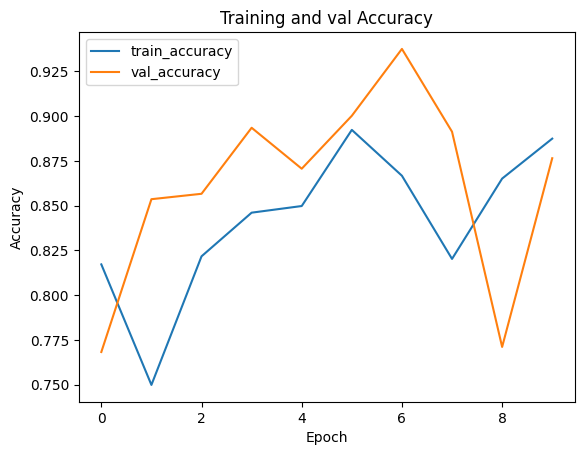

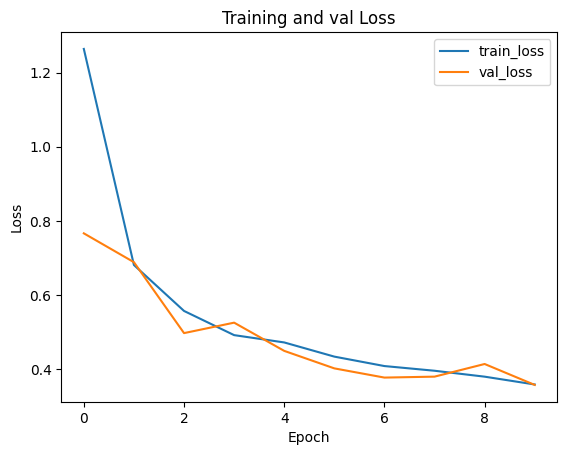

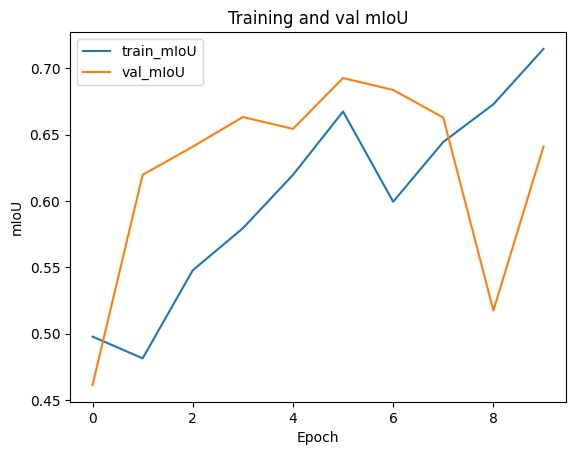

In [24]:
plt.figure()
plt.plot(train_accuracies, label="train_accuracy")
plt.plot(val_accuracies, label="val_accuracy")
plt.legend()

plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.title('Training and val Accuracy')

plt.figure()
plt.plot(train_losses, label="train_loss")
plt.plot(val_losses, label="val_loss")

plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and val Loss')

plt.figure()
plt.plot(train_mIoUs, label="train_mIoU")
plt.plot(val_mIoUs, label="val_mIoU")

plt.legend()
plt.xlabel('Epoch')
plt.ylabel('mIoU')
plt.title('Training and val mIoU')

# Evaluation

In [25]:
best_val_model_path = '/content/best_val_checkpoint_norm_aug_tensorboard.pth'
best_val_checkpoint = torch.load(best_val_model_path, map_location=torch.device(device))
# Before loading the state_dict of the model, make sure the "model" instance is 
# initiated by its corresponding class e.g. VGG16
model.load_state_dict(best_val_checkpoint['model'])

<All keys matched successfully>

In [26]:
class TestDataset(Dataset):
    
    def __init__(self, img_path, mask_path, X, transform=None):
        self.img_path = img_path
        self.mask_path = mask_path
        self.X = X
        self.transform = transform
      
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        img = cv2.imread(self.img_path + self.X[idx] + '.png')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.mask_path + self.X[idx] + '.png', cv2.IMREAD_GRAYSCALE)
        
        if self.transform is not None:
            aug = self.transform(image=img, mask=mask)
            img = Image.fromarray(aug['image'])
            mask = aug['mask']
        
        if self.transform is None:
            img = Image.fromarray(img)
        
        mask = torch.from_numpy(mask).long()
        
        return img, mask

df_test=test_df['id'].values
t_test = A.Resize(256, 256, interpolation=cv2.INTER_NEAREST)
test_set = TestDataset(TEST_IMAGE_PATH, TEST_MASK_PATH, df_test, transform=t_test)

In [27]:
def predict_image_mask_miou(model, image, mask, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    model.eval()
    t = T.Compose([T.ToTensor(), T.Normalize(mean, std)])
    image = t(image)
    model.to(device); image=image.to(device)
    mask = mask.to(device)
    with torch.no_grad():
        
        image = image.unsqueeze(0)
        mask = mask.unsqueeze(0)
        
        output = model(image)
        score = mIoU(output, mask)
        masked = torch.argmax(output, dim=1)
        masked = masked.cpu().squeeze(0)
    return masked, score

In [28]:
def test_miou_score(model, test_set):
    score_iou = []
    for i in tqdm(range(len(test_set))):
        img, mask = test_set[i]
        pred_mask, score = predict_image_mask_miou(model, img, mask)
        score_iou.append(score)
    return score_iou

In [29]:
mob_miou = test_miou_score(model, test_set)
np.mean(mob_miou)

  0%|          | 0/101 [00:00<?, ?it/s]

0.6943356325871296

In [30]:
def display_for_comparison(image, mask, pred_mask):

  fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,10))
  ax1.imshow(image)
  ax1.set_title('Picture');

  ax2.imshow(mask)
  ax2.set_title('Ground truth')
  ax2.set_axis_off()

  ax3.imshow(pred_mask)
  ax3.set_title('UNet-MobileNet | mIoU {:.3f}'.format(score))
  ax3.set_axis_off()

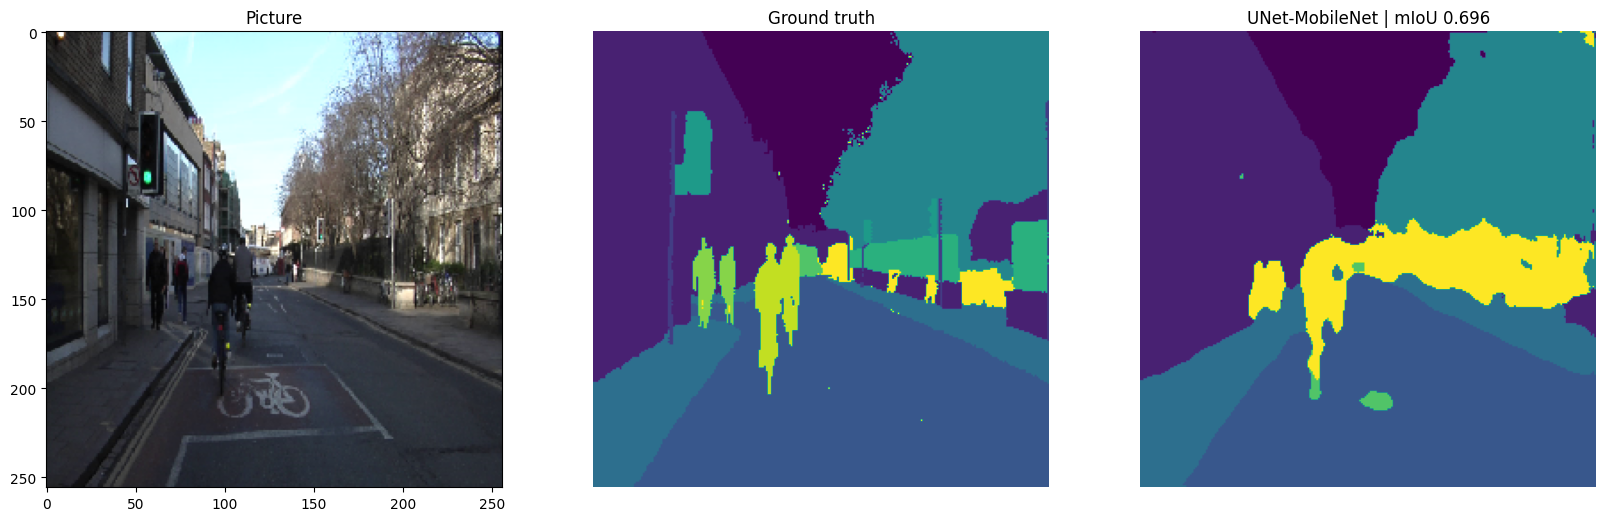

In [31]:
image, mask = test_set[3]
pred_mask, score = predict_image_mask_miou(model, image, mask)

display_for_comparison(image, mask, pred_mask)

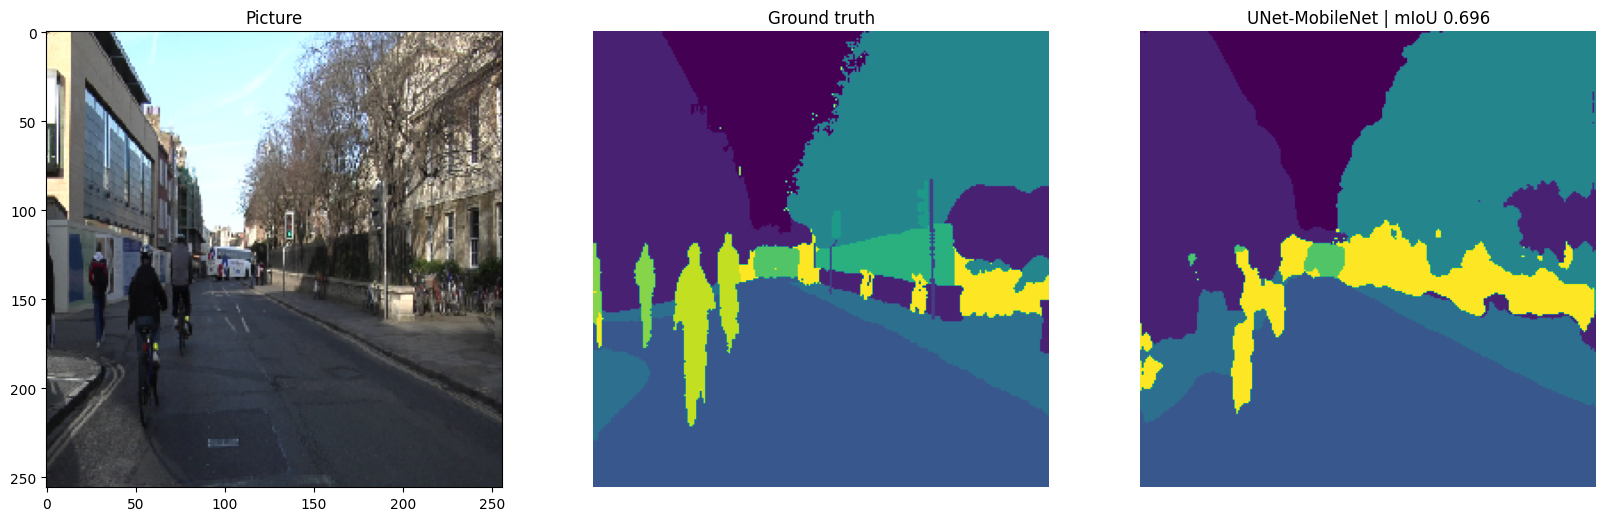

In [32]:
image2, mask2 = test_set[9]
pred_mask2, score2 = predict_image_mask_miou(model, image2, mask2)


display_for_comparison(image2, mask2, pred_mask2)

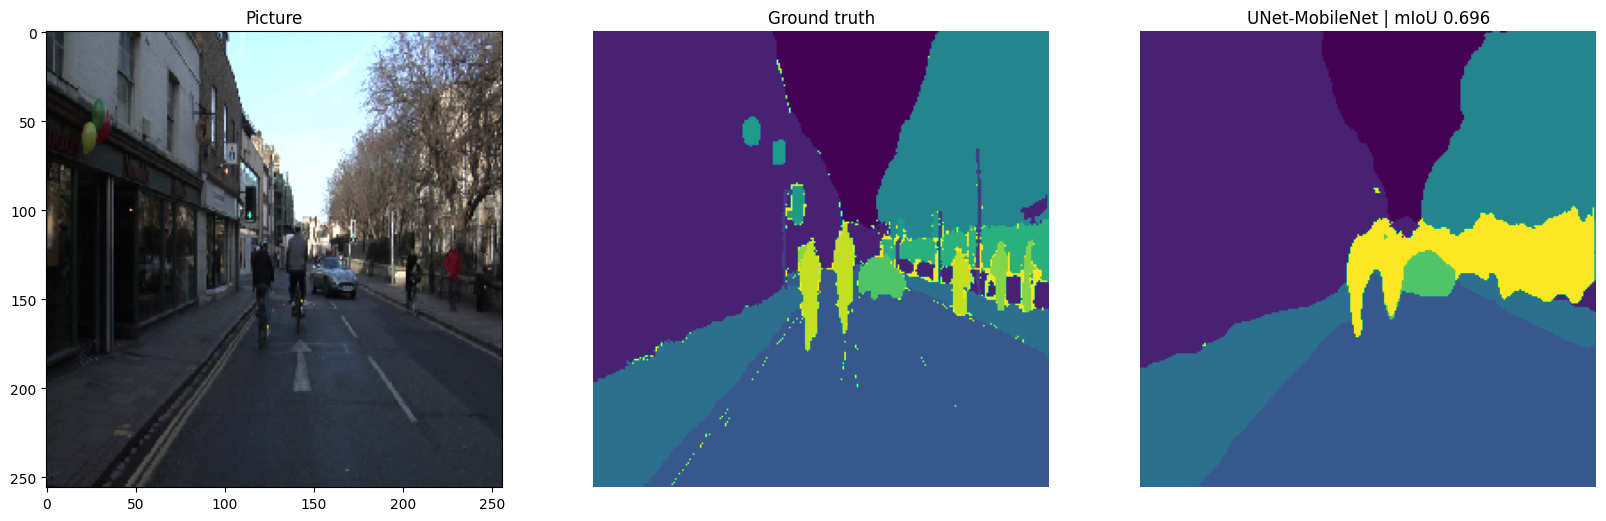

In [33]:
image3, mask3 = test_set[15]
pred_mask3, score3 = predict_image_mask_miou(model, image3, mask3)


display_for_comparison(image3, mask3, pred_mask3)

In [34]:
print('Test Set mIoU', np.mean(mob_miou))

Test Set mIoU 0.6943356325871296
